## Random Feature Model Experiments for SGD on Structured Features Paper

### Import necessary API's

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, vmap, jit
from jax.experimental import optimizers 
from jax import random
from google.colab import drive


### Optional if on google colab, can save files

In [2]:
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


### Define a Feature Map 

For data $\mathbf x \in \mathbb{R}^D$, sample a random projection matrix $G_{ij} \sim \mathcal{N}(0,1/D)$ and compute the nonlinear feature map.
$$\mathbf{\psi}(\mathbf{x}) = \phi(\mathbf{G}\mathbf x)$$

The covariance matrix for these features has the form
$$ \mathbf{\Sigma} = \left< \phi( \mathbf{G} \mathbf{x}) \phi(\mathbf G \mathbf x)^\top \right>_{\mathbf x}$$

In [4]:
def feature_map(X, N, nonlin):
  P,D = X.shape
  G = 10/np.sqrt(D) * np.random.standard_normal((N,D))
  G = jnp.array(G)
  F = nonlin( X @ G.T )
  F = F - jnp.mean(F)
  return F

tanh = lambda x: jnp.tanh(x)
linear = lambda x: x
relu = lambda x: x * jnp.heaviside(x,0)

P = 3000
D = 25
N = 3200

X = np.random.standard_normal((P,D))
F_tanh = feature_map(X, N, tanh)
F_relu = feature_map(X, N, relu)

def spectra(F):
  s = jnp.linalg.svd(F, compute_uv=False)
  sorted = s.sort()[::-1]
  return sorted

def sorted_decomp(F, y, square = True):
  u, s, _ = jnp.linalg.svd(F)
  inds = jnp.argsort(s)[::-1]
  s = s[inds]
  u = u[:,inds]
  vk = (u.T @ y)**2 / np.sum(y**2)
  if square == False:
    v_non = u.T @ y / np.sqrt(np.sum(y**2))
    return s, v_non
  return s, vk



### Compute theoretical learning curves

The expected test loss after $t$ steps has the form

$$\left< L_t \right> = \mathbf{\lambda}^\top \mathbf{A}^t \mathbf{v}^2$$ where 

$$ A_{ij} = \left(1-2\eta\lambda_i + \eta^2 \frac{m+1}{m}\lambda_i \right)\delta_{ij} + \frac{\eta^2}{m} \lambda_i \lambda_j$$

In [5]:
def theory(s, teach, eta, T, m = 1, noise = 0):
    A = jnp.eye(len(s)) - 2*eta*jnp.diag(s) + 1.0*(m+1)/m *eta**2 * jnp.diag(s**2) + 1.0/m * eta**2 * jnp.outer(s, s)
    Inv_mat = jnp.linalg.inv(jnp.eye(A.shape[0]) - A)
    x = s.copy()
    theory_loss = []
    for t in range(T):
        losst = 0.5 * jnp.dot(x, teach) + 0.5/m * eta**2 * noise**2 * jnp.dot(s, Inv_mat @ (s-x))
        theory_loss += [losst]
        x = A @ x
    return theory_loss


def theory_eig(s, teach, eta, t, m=1, noise = 0):
  A = jnp.eye(len(s)) - 2*eta*jnp.diag(s) + 1.0*(m+1)/m *eta**2 * jnp.diag(s**2) + 1.0/m * eta**2 * jnp.outer(s, s)
  eigA, VA = jnp.linalg.eigh(A)
  Inv_mat = jnp.linalg.inv(jnp.eye(A.shape[0]) - A)
  left = VA.T @ s
  right = VA.T @ teach

  Inv_mat = jnp.linalg.inv(jnp.eye(A.shape[0]) - A)
  theory_loss = []
  
  losst = 0.5 * jnp.dot(left, eigA**t * right) + 0.5/m * eta**2 * noise**2 * jnp.dot(s, Inv_mat @ (s - eigA**t * left))
  return losst

def theory_white(t, eta, N, m=1):
  return (1 - 2*eta + (m+1)/m * eta**2 + 1/m *N*eta**2)**t
def theory_pop_white(t, eta):
  return (1-eta)**(2*t)

def theory_var(s, teach, eta, T, m = 1):
  A = jnp.eye(len(s)) - 2*eta*jnp.diag(s) + 1.0*(m+1)/m *eta**2 * jnp.diag(s**2) + 1.0/m * eta**2 * jnp.outer(s, s)
  B = jnp.eye(len(s))-eta*jnp.outer(s, jnp.ones(len(s)))-eta*jnp.outer(jnp.ones(len(s)),s)+ eta**2 * 1.0*(m+1)/m * jnp.outer(s,s)
  B = B - jnp.diag( jnp.diag(B) )
  x = teach.copy()
  theory_loss = []
  for t in range(T): 
      losst = jnp.dot(s**2, x**2) + jnp.dot(teach*s, jnp.dot(B**(2*t), s*teach) )
      #losst = jnp.dot(s**2, x**2)
      theory_loss += [losst]
      x = A @ x
  return theory_loss

In [6]:
def train_fn(F, y, T, eta, m = 1, noise = 0):
  loss = jit( lambda w, X, y: 0.5*jnp.mean( (jnp.dot(X, w)-y)**2 ) )
  gloss = jit( grad(loss, 0) )
  w = jnp.zeros(F.shape[1])

  eta_expt = eta*F.shape[0]
  opt_init, opt_update, get_params = optimizers.sgd(eta_expt)
  opt_state = opt_init(w)

  losses = []
  for t in range(T):
    start = (t * m) % F.shape[0]
    opt_state = opt_update(t, gloss(get_params(opt_state),F[start:start+m,:],y[start:start+m]+noise*jnp.array(np.random.standard_normal(m))), opt_state)
    losses += [loss(get_params(opt_state), F, y)]
  return losses

In [7]:

import tensorflow as tf
import tensorflow_datasets as tfds

num_tot = 50000
num_classes = 10
size = 32
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024).batch(num_tot)

plt.rcParams.update({'font.size': 12})

for i,ex in enumerate(ds):
  Xtf = ex['image']
  image = Xtf.numpy() / 255.0
  X = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]*image.shape[3]))
  X = X / np.outer(np.linalg.norm(X, axis = 1), np.ones(X.shape[1]))
  y = ex['label'].numpy()
  #y_mat = np.eye(num_classes)[y] 
  break

inds_89 = [i for i in range(y.shape[0]) if y[i]==8 or y[i]==9]
X89 = X[inds_89,:]
y89 = y[inds_89]
y89 = 1.0*(y89==8) -1.0*(y89==9)

"""
X89 = X
y89 = np.zeros(y.shape)
for c in range(10):
  if c % 2 ==0:
    y89 += 1.0 * (y == c)
  else:
    y89 += -1.0 * (y == c)
"""

num_tot = 50000
num_classes = 10
size = 32
name = 'cifar10'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024).batch(num_tot)

plt.rcParams.update({'font.size': 12})

for i,ex in enumerate(ds):
  Xtf = ex['image']
  image = Xtf.numpy() / 255.0
  X_C = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]*image.shape[3]))
  X_C = X_C / np.outer(np.linalg.norm(X_C, axis = 1), np.ones(X_C.shape[1]))
  y_C = ex['label'].numpy()
  #y_mat = np.eye(num_classes)[y] 
  break

inds_89 = [i for i in range(y_C.shape[0]) if y_C[i]==8 or y_C[i]==9]
X89_C = X_C[inds_89,:]
y89_C = y_C[inds_89]
y89_C = 1.0*(y89_C==8) - 1.0*(y89_C==9)

"""
X89_C = X_C
y89_C = np.zeros(y_C.shape)
for c in range(10):
  if c % 2 ==0:
    y89_C += 1.0 * (y_C == c)
  else:
    y89_C += -1.0 * (y_C == c)
"""

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteJ8XAZV/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteJ8XAZV/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


'\nX89_C = X_C\ny89_C = np.zeros(y_C.shape)\nfor c in range(10):\n  if c % 2 ==0:\n    y89_C += 1.0 * (y_C == c)\n  else:\n    y89_C += -1.0 * (y_C == c)\n'

In [ ]:
print(X89_C.shape)
print(X89_C)

(50000, 3072)
[[0.02005054 0.02005054 0.02005054 ... 0.01809158 0.01809158 0.01809158]
 [0.03227202 0.03240483 0.03267044 ... 0.00371859 0.0059763  0.01022611]
 [0.0192574  0.0123348  0.00629327 ... 0.02970422 0.03008182 0.03096287]
 ...
 [0.00805227 0.00861734 0.00889988 ... 0.0303726  0.02867739 0.0264171 ]
 [0.01353016 0.01312016 0.0079951  ... 0.01086513 0.01148014 0.00758509]
 [0.03162795 0.03179619 0.03095502 ... 0.04289962 0.04273138 0.04289962]]


In [8]:
P_sub = 2500
N = 4000

# MNIST RELU
F_MNIST = feature_map(X89[0:P_sub,:], N, relu)
s, vk = sorted_decomp(F_MNIST, y89[0:P_sub])

F_MNIST = F_MNIST / s[0]
s = s/s[0]

# MNIST TANH
F_MNIST_tanh = feature_map(X89[0:P_sub,:], N, tanh)
s_t, vk_t = sorted_decomp(F_MNIST_tanh, y89[0:P_sub])
F_MNIST_tanh = F_MNIST_tanh / s_t[0]
s_t = s_t/s_t[0]

# ISO Features RELU
X = np.random.standard_normal((P_sub, 784))

F_MNIST_iso = feature_map(X, N, relu)
print(F_MNIST_iso.shape)
s_iso, vk_iso = sorted_decomp(F_MNIST_iso, y89[0:P_sub])

F_MNIST_iso = F_MNIST_iso / s_iso[0]
s_iso = s_iso/s_iso[0]

# CIFAR-RELU
F_CIFAR = feature_map(X89_C[0:P_sub], N, relu)
s_c, vk_c = sorted_decomp(F_CIFAR, y89_C[0:P_sub])

F_CIFAR = F_CIFAR / s_c[0]
s_c = s_c/s_c[0]



(2500, 4000)


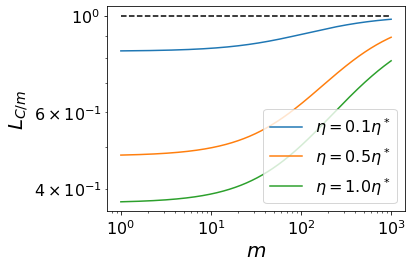

0.1
0.3
0.5
0.1
0.3
0.5
[[0.25698152, 0.31204265, 0.37143677, 0.43043202, 0.4693448], [0.13713437, 0.17716818, 0.23027563, 0.32362396, 0.41616154], [0.12244478, 0.13714121, 0.17406704, 0.25190836, 0.37055793]]
[[0.011615465, 0.008298762, 0.007172362, 0.005092019, 0.0018328739], [0.014714378, 0.016935987, 0.014698934, 0.009648443, 0.0055642137], [0.020385938, 0.017576898, 0.01906778, 0.014050921, 0.0074845534]]


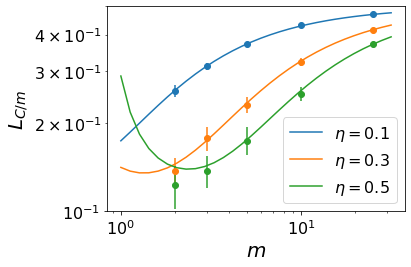

0.1
0.3
0.5


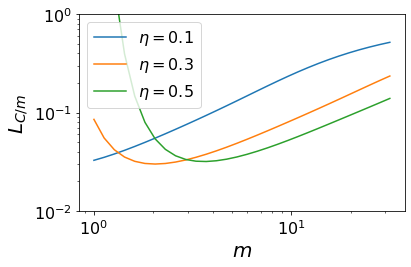

In [17]:
C = 100
N = 100
mvals = jnp.logspace(0, 3, 1000)
m = 10
scale_eta = [0.1, 0.5,1]
all_res = []
for scale in scale_eta:
  res = []
  for m in mvals:
    t = C/m
    eta = scale*m/(m+N+1)
    res += [theory_white(t, eta, N, m)]
  all_res += [res]

plt.rcParams.update({'font.size': 16})


plt.loglog(mvals, jnp.ones(len(mvals)), '--',color = 'black')
for i,r in enumerate(all_res):
  plt.plot(mvals, r, label = r'$\eta = %0.1f \eta^*$' % scale_eta[i])
plt.legend()
plt.xlabel(r'$m$',fontsize = 20)
plt.ylabel(r'$L_{C/m}$',fontsize = 20)
plt.tight_layout()
plt.savefig(root_dir + 'isotropic_optimal_m.pdf')
plt.show()



mvals = jnp.logspace(0, 1.5, 30)
scale_eta = [0.1, 0.3, 0.5]
all_res = []
eta = 1
for scale in scale_eta:
  print(scale)
  res = []
  for m in mvals:
    t = C/m
    eta = scale
    #eta = scale*m/(m+N+1)
    res += [theory_eig(s**2, vk/s**2, eta, t, m)]
  all_res += [res]

m_expt_vals = [2, 3, 5, 10, 25]
all_expt = []
all_expt_std = []
y_expt = y89[0:P_sub]

for scale in scale_eta:
  print(scale)
  res = []
  res_std = []
  for m in m_expt_vals:
    arr = []
    for i in range(30):
      random_perm = np.random.permutation(P_sub)
      arr += [ train_fn(F_MNIST[random_perm,:], y_expt[random_perm], int(C/m), scale, m = m)[-1] ]
    res += [ np.mean(arr )]
    res_std += [ np.std(arr) ]
  all_expt += [res]
  all_expt_std += [res_std]

print(all_expt)
print(all_expt_std)

#plt.loglog(mvals, jnp.dot(power_law_s,teach)*jnp.ones(len(mvals)), '--',color = 'black')
for i,r in enumerate(all_res):
  plt.loglog(mvals, r, label = r'$\eta = %0.1f$' % scale_eta[i], color = 'C%d' % i)
  plt.errorbar(m_expt_vals, all_expt[i], jnp.array(all_expt_std[i]), fmt='o', color = 'C%d' % i)
plt.legend()
plt.ylim([1e-1,0.5])
plt.xlabel(r'$m$',fontsize = 20)
plt.ylabel(r'$L_{C/m}$',fontsize = 20)
plt.tight_layout()
plt.savefig(root_dir + 'optimal_m_powerlaw.pdf')
plt.show()

N = 100
b = 1
a = 2
teach = jnp.linspace(1,N,N)**(-a+b)
power_law_s = jnp.linspace(1,N, N)**(-b)


scale_eta = [0.1, 0.3, 0.5]
all_res = []
eta = 1
for scale in scale_eta:
  print(scale)
  res = []
  for m in mvals:
    t = C/m
    eta = scale
    #eta = scale*m/(m+N+1)
    res += [theory_eig(power_law_s, teach, eta, t, m)]
  all_res += [res]



#plt.loglog(mvals, jnp.dot(power_law_s,teach)*jnp.ones(len(mvals)), '--',color = 'black')
for i,r in enumerate(all_res):
  plt.loglog(mvals, r, label = r'$\eta = %0.1f$' % scale_eta[i])
plt.legend()
plt.ylim([1e-2,1])
plt.xlabel(r'$m$',fontsize = 20)
plt.ylabel(r'$L_{C/m}$',fontsize = 20)
plt.tight_layout()
plt.savefig(root_dir + 'optimal_m_powerlaw_synthetic.pdf')
plt.show()



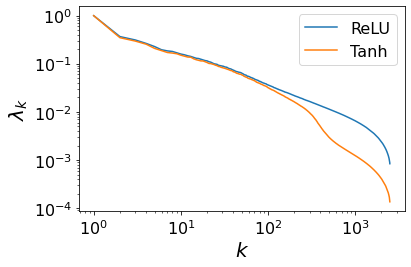

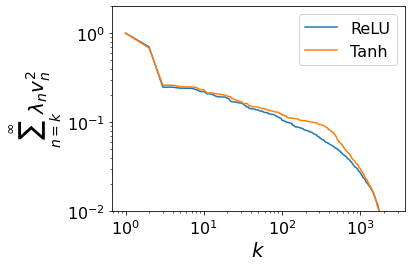

In [ ]:
plt.rcParams.update({'font.size': 16})
fs = 20
plt.loglog(jnp.linspace(1,len(s), len(s)), s, label = r'ReLU')
plt.loglog(jnp.linspace(1,len(s), len(s)), s_t, label = 'Tanh')
plt.xlabel(r'$k$',fontsize = fs)
plt.ylabel(r'$\lambda_k$',fontsize=fs)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'spectra_relu_tanh_mnist_random_features.pdf')
plt.show()

cum_sum = 1-jnp.cumsum(vk)/jnp.sum(vk)
cum_sum_tanh = 1- jnp.cumsum(vk_t)/jnp.sum(vk_t)

plt.loglog(jnp.linspace(1,len(s), len(s)),cum_sum, label = r'ReLU')
plt.loglog(jnp.linspace(1,len(s), len(s)), cum_sum_tanh, label = r'Tanh')
plt.xlabel(r'$k$',fontsize = fs)
plt.ylabel(r'$\sum_{n=k}^\infty \lambda_n v_n^2$',fontsize=fs)
plt.ylim([1e-2, 2])
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'task_power_relu_tanh_mnist_random_features.pdf')
plt.show()

In [ ]:
eta = 0.6
T = 200
m = 2

all_th = []
all_var = []
all_mean = []
all_std = []

eta_vals = [0.1, 0.5]
for eta in eta_vals:
  print(eta)
  th = 2*jnp.array( theory(s**2, vk / s**2, eta, T, m = m) )
  #expt = train_fn(F_MNIST, y89[0:P_sub], T, eta, m = m)
  all_expt = []
  for n in range(40):
    perm = np.random.permutation(P_sub)
    all_expt += [ train_fn(F_MNIST[perm,:], y89[0:P_sub][perm], T, eta, m = m) ] 
  all_expt = 2*jnp.array(all_expt)
  var = 2*jnp.array( theory_var(s**2, vk / s**2, eta, T, m = m) )
  
  all_th +=[th]
  all_var += [var]
  all_mean += [jnp.mean(all_expt, axis =0)]
  all_std += [jnp.std(all_expt, axis =0)]


0.1
0.5


In [ ]:
eta = 0.3
T = 8000
m = 5
th = jnp.array( theory(s**2, vk / s**2, eta, T, m = m) )
expt = train_fn(F_MNIST, y89[0:P_sub], T, eta, m = m)
var = jnp.array( theory_var(s**2, vk / s**2, eta, T, m = m) )


th_tanh = jnp.array( theory(s_t**2, vk_t / s_t**2, eta, T, m = m) )
expt_tanh = train_fn(F_MNIST_tanh, y89[0:P_sub], T, eta, m=m)

th_cifar = jnp.array( theory(s_c**2, vk_c / s_c**2, eta, T, m = m) )
expt_cifar = train_fn(F_CIFAR, y89_C[0:P_sub], T, eta, m=m)

eta_iso = 0.5/P_sub
th_iso = jnp.array( theory(s_iso**2, vk_iso / s_iso**2, eta_iso, T, m = m) )
expt_iso = jnp.array( train_fn(F_MNIST_iso, y89[0:P_sub], T, eta_iso, m =  m) )

print(expt_cifar)



KeyboardInterrupt: ignored

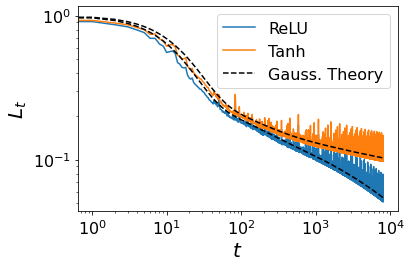

In [ ]:
fs = 20
plt.rcParams.update({'font.size': 16})

plt.loglog(2*jnp.array(expt), label = r'ReLU')
plt.loglog(2*jnp.array(expt_tanh), label = r'Tanh')
plt.loglog(2*th, '--', color = 'black', label = r'Gauss. Theory')
plt.loglog(2*th_tanh, '--', color = 'black')
plt.xlabel(r'$t$',fontsize = fs)
plt.ylabel(r'$L_t$',fontsize=fs)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir +'test_err_relu_tanh_mnist_random_features_m_5.pdf')
plt.show()

[DeviceArray(0.49710354, dtype=float32), DeviceArray(0.49822456, dtype=float32), DeviceArray(0.498541, dtype=float32), DeviceArray(0.49878657, dtype=float32), DeviceArray(0.50255, dtype=float32), DeviceArray(0.49219128, dtype=float32), DeviceArray(0.51522654, dtype=float32), DeviceArray(0.490946, dtype=float32), DeviceArray(0.48637718, dtype=float32), DeviceArray(0.48337674, dtype=float32), DeviceArray(0.48044735, dtype=float32), DeviceArray(0.49025878, dtype=float32), DeviceArray(0.5149699, dtype=float32), DeviceArray(0.5449913, dtype=float32), DeviceArray(0.56722003, dtype=float32), DeviceArray(0.50134706, dtype=float32), DeviceArray(0.46980146, dtype=float32), DeviceArray(0.4711818, dtype=float32), DeviceArray(0.46953046, dtype=float32), DeviceArray(0.47181502, dtype=float32), DeviceArray(0.466966, dtype=float32), DeviceArray(0.4876804, dtype=float32), DeviceArray(0.48106518, dtype=float32), DeviceArray(0.4806772, dtype=float32), DeviceArray(0.4575289, dtype=float32), DeviceArray(0.

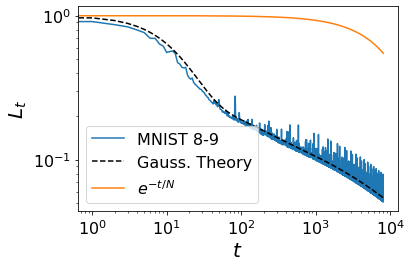

In [ ]:
fs = 20
print(expt_cifar)

plt.rcParams.update({'font.size': 16})
#plt.figure(figsize=(6.4,4))
plt.loglog(2*jnp.array(expt), label = 'MNIST 8-9')
plt.loglog(2*th, '--', color = 'black', label = 'Gauss. Theory')
plt.loglog(np.exp( - eta*np.linspace(1,T,T)/4000 ) , label = r'$e^{-t/N}$')
plt.xlabel(r'$t$',fontsize = fs)
plt.ylabel(r'$L_t$',fontsize=fs)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir +'test_err_mnist_random_power_law_RF.pdf')
plt.show()

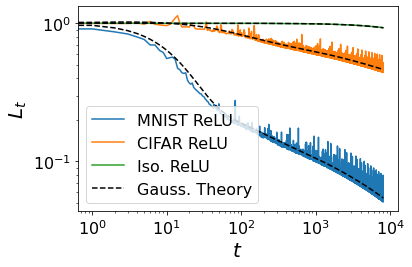

In [ ]:
fs = 20
plt.rcParams.update({'font.size': 16})

plt.loglog(2*jnp.array(expt), label = 'MNIST ReLU' )
plt.loglog(2*jnp.array(expt_cifar), label = 'CIFAR ReLU')
plt.loglog(2*expt_iso, label = 'Iso. ReLU')
plt.loglog(2*th, '--',color = 'black', label ='Gauss. Theory')
plt.loglog(2*th_iso, '--',color = 'black')
plt.loglog(2*th_cifar, '--', color = 'black')
plt.xlabel(r'$t$',fontsize = fs)
plt.ylabel(r'$L_t$',fontsize=fs)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir +'structured_data.pdf')
plt.show()

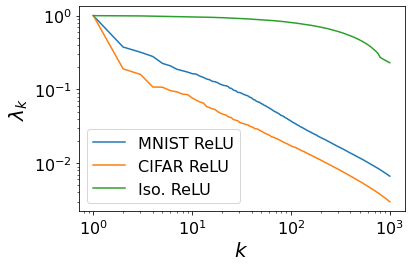

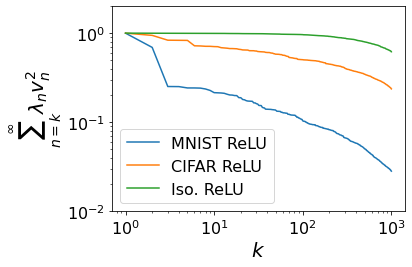

In [ ]:
plt.loglog(jnp.linspace(1,1000,1000), s[0:1000], label = r'MNIST ReLU')
plt.loglog(jnp.linspace(1,1000,1000), s_c[0:1000], label = 'CIFAR ReLU')
plt.loglog(jnp.linspace(1,1000,1000), s_iso[0:1000], label = 'Iso. ReLU')
plt.xlabel(r'$k$',fontsize = fs)
plt.ylabel(r'$\lambda_k$',fontsize=fs)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'spectra_relu_mnist_vs_iso.pdf')
plt.show()

cum_sum = 1- jnp.cumsum(vk) / jnp.sum(vk)
cum_sum_iso = 1-jnp.cumsum(vk_iso)/jnp.sum(vk_iso)
cum_sum_c = 1-jnp.cumsum(vk_c) / jnp.sum(vk_c)

plt.loglog(jnp.linspace(1,1000,1000), cum_sum[0:1000], label = r'MNIST ReLU')
plt.loglog(jnp.linspace(1,1000,1000), cum_sum_c[0:1000], label = r'CIFAR ReLU')
plt.loglog(jnp.linspace(1,1000,1000), cum_sum_iso[0:1000], label = r'Iso. ReLU')
plt.xlabel(r'$k$',fontsize = fs)
plt.ylabel(r'$\sum_{n=k}^\infty \lambda_n v_n^2$',fontsize=fs)
plt.ylim([1e-2, 2])
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'task_power_relu_mnist_vs_iso.pdf')
plt.show()

In [ ]:
eta_vals = [0.05, 0.1, 0.2]
#eta_vals = [0.05, 0.1, 0.2]

T = 1000

all_theory = []
all_expt = []
for i, eta in enumerate(eta_vals):
  all_theory += [jnp.array( theory(s**2, vk / s**2, eta, T) )]
  all_expt += [jnp.array( train_fn(F_MNIST, y89[0:P_sub], T, eta) )]


eta = 0.25
m_vals = [1, 5, 10]
all_theory_m = []
all_expt_m = []

for i, m in enumerate(m_vals):
  all_theory_m += [jnp.array( theory(s**2, vk / s**2, eta, T, m=m) )]
  all_expt_m += [jnp.array( train_fn(F_MNIST, y89[0:P_sub], T, eta, m=m) )]

all_theory_noise = []
all_expt_noise = []
all_noise = [0, 0.5, 1]
num_rep = 10
for i, noise in enumerate(all_noise):
  all_theory_noise += [jnp.array( theory(s**2, vk / s**2, eta, T, m = 1, noise = noise) )]
  mean = jnp.zeros(T)
  for n in range(num_rep):
    mean += 1/num_rep * jnp.array( train_fn(F_MNIST, y89[0:P_sub], T, eta, m = 1, noise=noise) )
  all_expt_noise += [mean]

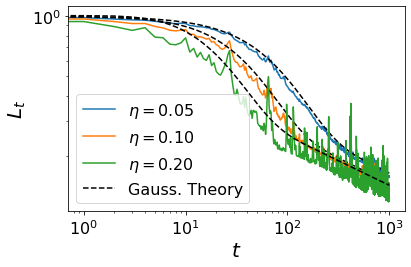

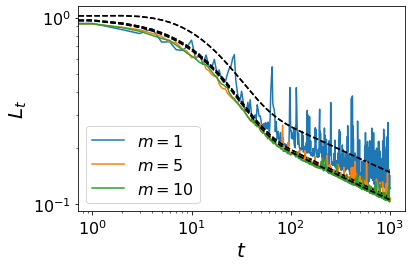

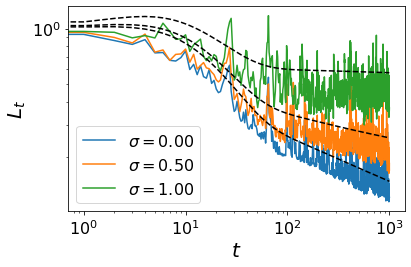

In [ ]:
fs = 20
plt.rcParams.update({'font.size': 16})

for i, eta in enumerate(eta_vals):
  plt.loglog(2*all_expt[i], label = r'$\eta=%0.2f$' % eta)
  if i == len(eta_vals)-1:
    plt.loglog(2*all_theory[i], '--', color = 'black', label = 'Gauss. Theory')
  else:
    plt.loglog(2*all_theory[i], '--', color = 'black')

plt.legend()
plt.xlabel(r'$t$',fontsize = fs)
plt.ylabel(r'$L_t$',fontsize = fs)
plt.tight_layout()
plt.savefig(root_dir + 'mnist_random_feature_vary_lr.pdf')
plt.show()


for i, m in enumerate(m_vals):
  plt.loglog(2*all_expt_m[i], label = r'$m=%d$' % m)
  plt.loglog(2*all_theory_m[i], '--', color = 'black')
  plt.loglog(2*all_theory_m[i], '--', color = 'black')

plt.legend()
plt.xlabel(r'$t$',fontsize = fs)
plt.ylabel(r'$L_t$',fontsize = fs)
plt.tight_layout()
plt.savefig(root_dir + 'mnist_random_feature_vary_batch.pdf')
plt.show()


for i, noise in enumerate(all_noise):
  plt.loglog(2*all_expt_noise[i], label = r'$\sigma=%0.2f$' % noise)
for i, noise in enumerate(all_noise):
  plt.loglog(2*all_theory_noise[i], '--', color = 'black')

plt.legend()
plt.xlabel(r'$t$',fontsize = fs)
plt.ylabel(r'$L_t$',fontsize = fs)
plt.tight_layout()
plt.savefig(root_dir + 'mnist_random_feature_vary_noise.pdf')
plt.show()

In [ ]:
# compute variance example ... 


(2500, 4000)
-1.5127896e-12
6.184941e-12
-2.9141355e-12
1.0285776e-11


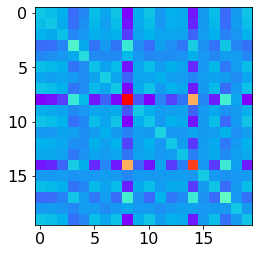

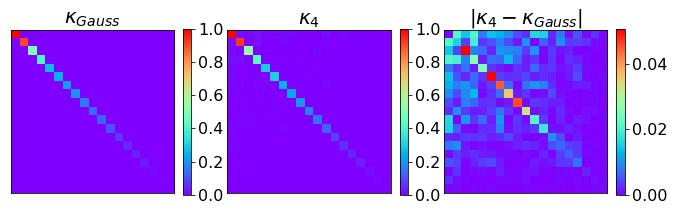

-6.750334e-14
1.5952143e-13
-1.4639695e-13
2.2353102e-13


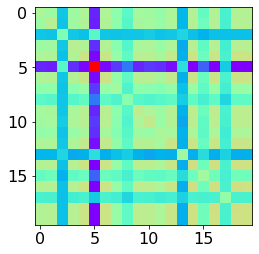

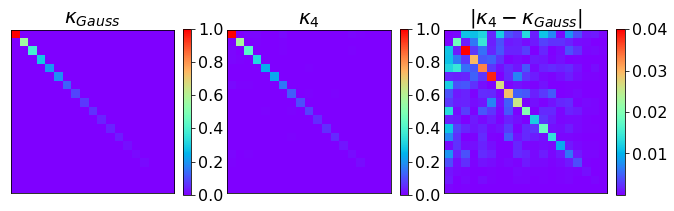

In [ ]:
# compute fourth moment stuff

print(F_MNIST.shape)
N = 20
F100 = F_MNIST[:,0:N]

Sigma = 1/F100.shape[0] * F100.T @ F100
K = F100 @ F100.T
D = jnp.diag( jnp.diag(K) )

K4 =  1/F100.shape[0] * F100.T @ D @ F100
print(jnp.amin(K4))
print(jnp.amax(K4))


K_gauss = 2 * Sigma.T @ Sigma + Sigma * jnp.trace(Sigma)
print(jnp.amin(K_gauss))
print(jnp.amax(K_gauss))


plt.imshow(Sigma, cmap = 'rainbow')
plt.show()

#print(np.amax(K_gauss-K4) / np.amax(K_gauss))
#print(np.amin(K_gauss-K4)/ np.amax(K_gauss))

#plt.imshow(K_gauss - K4 , cmap = 'rainbow')
#plt.show()

eigs,vecs = jnp.linalg.eigh(Sigma)
indsort = jnp.argsort(eigs)[::-1]
eigs = eigs[indsort[1:]]
vecs = vecs[:,indsort[1:]]


kappa_gauss = 2 * jnp.diag(eigs**2) + jnp.sum(eigs) * jnp.diag(eigs)
kappa_4 = vecs.T @ K4 @ vecs

kappa_4 = kappa_4 / jnp.amax(kappa_4)
kappa_gauss = kappa_gauss/jnp.amax(kappa_gauss)




plt.figure(figsize=(10.5,3.2))

plt.subplot(1,3,1)
plt.imshow(kappa_gauss,cmap = 'rainbow', vmin = 0, vmax = 1)
plt.colorbar(fraction=0.046)
plt.title(r'$\kappa_{Gauss}$',fontsize = 20)
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(kappa_4, cmap = 'rainbow', vmin = 0, vmax = 1)
plt.colorbar(fraction=0.046)
plt.title(r'$\kappa_4$',fontsize = 20)
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(jnp.abs(kappa_4-kappa_gauss), cmap='rainbow')
plt.colorbar(fraction=0.046)
plt.title(r'$|\kappa_4 - \kappa_{Gauss}|$',fontsize = 20)
plt.xticks([])
plt.yticks([])
plt.savefig(root_dir + 'non_gauss_diff_effect_mnist.pdf')
plt.show()

N = 20
F100 = F_CIFAR[:,0:N]

Sigma = 1/F100.shape[0] * F100.T @ F100
K = F100 @ F100.T
D = jnp.diag( jnp.diag(K) )

K4 =  1/F100.shape[0] * F100.T @ D @ F100
print(jnp.amin(K4))
print(jnp.amax(K4))


K_gauss = 2 * Sigma.T @ Sigma + Sigma * jnp.trace(Sigma)
print(jnp.amin(K_gauss))
print(jnp.amax(K_gauss))


plt.imshow(Sigma, cmap = 'rainbow')
plt.show()



#print(np.amax(K_gauss-K4) / np.amax(K_gauss))
#print(np.amin(K_gauss-K4)/ np.amax(K_gauss))

#plt.imshow(K_gauss - K4 , cmap = 'rainbow')
#plt.show()

eigs,vecs = jnp.linalg.eigh(Sigma)
indsort = jnp.argsort(eigs)[::-1]
eigs = eigs[indsort[1:]]
vecs = vecs[:,indsort[1:]]

kappa_gauss = 2 * jnp.diag(eigs**2) + jnp.sum(eigs) * jnp.diag(eigs)
kappa_4 = vecs.T @ K4 @ vecs

kappa_4 = kappa_4 / jnp.amax(kappa_4)
kappa_gauss = kappa_gauss/jnp.amax(kappa_gauss)



plt.figure(figsize=(10.5,3.2))

plt.subplot(1,3,1)
plt.imshow(kappa_gauss,cmap = 'rainbow', vmin = 0, vmax = 1)
plt.colorbar(fraction=0.046)
plt.title(r'$\kappa_{Gauss}$',fontsize = 20)
plt.xticks([])
plt.yticks([])

#plt.show()

plt.subplot(1,3,2)
plt.imshow(kappa_4, cmap = 'rainbow', vmin = 0, vmax = 1)
plt.colorbar(fraction=0.046)
plt.title(r'$\kappa_4$',fontsize = 20)
plt.xticks([])
plt.yticks([])
#plt.tight_layout()

plt.subplot(1,3,3)
plt.imshow(jnp.abs(kappa_4-kappa_gauss), cmap='rainbow')
plt.colorbar(fraction=0.046)
plt.title(r'$|\kappa_4 - \kappa_{Gauss}|$',fontsize = 20)
plt.xticks([])
plt.yticks([])
#plt.tight_layout()
plt.savefig(root_dir + 'non_gauss_diff_effect_cifar.pdf')
plt.show()
